In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import ConfusionMatrixDisplay



In [2]:
# Display setting to better visualize notebook
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',10)
pd.set_option('display.width',1000)

In [3]:
# Read Aggregated  data
df = pd.read_csv('New_features.csv')

In [4]:
df.shape

(5410, 13)

In [5]:
df.columns

Index(['Provider', 'IP_average_claim_duration', 'OP_average_claim_duration', 'PotentialFraud', 'IP_Claims_Total', 'OP_Claims_Total', 'IP_Averagedaysinhospital', 'IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt', 'IP_total_diagnosis', 'OP_total_diagnosis', 'IP_total_procedures', 'OP_total_procedures'], dtype='object')

In [6]:
df.head()

,Provider,IP_average_claim_duration,OP_average_claim_duration,PotentialFraud,IP_Claims_Total,OP_Claims_Total,IP_Averagedaysinhospital,IPAnnualDeductibleAmt,OPAnnualDeductibleAmt,IP_total_diagnosis,OP_total_diagnosis,IP_total_procedures,OP_total_procedures
0,PRV51001,5.0,1.0,No,97000.0,7640.0,5.0,890.0,475.0,36.0,44.0,3.0,0.0
1,PRV51003,5.0,2.0,Yes,573000.0,32670.0,5.0,823.0,665.0,503.0,190.0,48.0,0.0
2,PRV51004,0.0,1.0,No,0.0,52170.0,0.0,454.0,601.0,0.0,385.0,0.0,0.0
3,PRV51005,0.0,1.0,Yes,0.0,280910.0,0.0,399.0,476.0,0.0,3016.0,0.0,0.0
4,PRV51007,5.0,1.0,No,19000.0,14710.0,5.0,424.0,431.0,22.0,193.0,1.0,0.0


In [7]:
X=df.drop(columns=['Provider','PotentialFraud'])

In [8]:
X.shape

(5410, 11)

In [9]:
y=df['PotentialFraud'].map({'Yes': 1, 'No': 0}) 

In [10]:
y

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: PotentialFraud, Length: 5410, dtype: int64

In [42]:
# comparison with and without tuning

Random Forest Without Hyperparameter Tuning:
Accuracy: 0.9418
Precision: 0.7500
Recall: 0.5644
F1-score: 0.6441
ROC-AUC: 0.9448
Random Forest With Hyperparameter Tuning:
Accuracy: 0.9427
Precision: 0.7532
Recall: 0.5743
F1-score: 0.6517
ROC-AUC: 0.9571


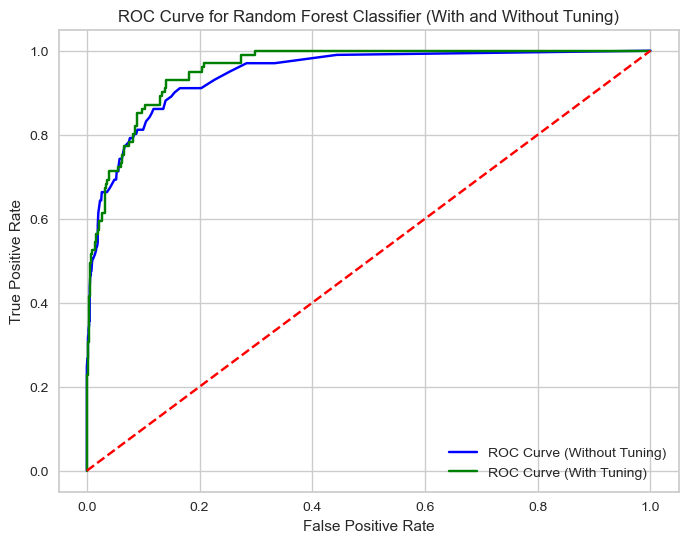

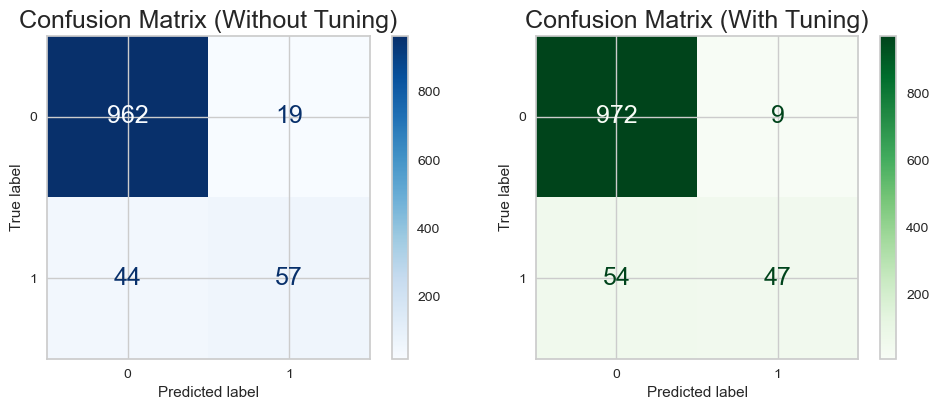

In [48]:
# Random Forest
# Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------ Random Forest without Hyperparameter Tuning ------

# Create and train Random Forest model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])

model.fit(X_train, y_train)

# Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Random Forest Without Hyperparameter Tuning:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')

# Confusion Matrix for Random Forest without Tuning
conf_matrix = confusion_matrix(y_test, y_pred)

# ------ Random Forest with Hyperparameter Tuning ------

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Create GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make Predictions and Evaluate the Best Model
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, pos_label=1)
recall_best = recall_score(y_test, y_pred_best, pos_label=1)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_prob_best)

print(f'Random Forest With Hyperparameter Tuning:')
print(f'Accuracy: {accuracy_best:.4f}')
print(f'Precision: {precision_best:.4f}')
print(f'Recall: {recall_best:.4f}')
print(f'F1-score: {f1_best:.4f}')
print(f'ROC-AUC: {roc_auc_best:.4f}')

# Visualize the ROC Curve for both models on the same graph
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_prob_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (Without Tuning)')
plt.plot(fpr_best, tpr_best, color='green', label='ROC Curve (With Tuning)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier (With and Without Tuning)')
plt.legend(loc='lower right')# Define a smaller figure size
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Function to plot confusion matrix with larger text labels
def plot_conf_matrix(ax, conf_matrix, title, cmap):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=cmap, ax=ax, values_format='d')  # 'd' ensures integer display
    ax.set_title(title, fontsize=18)

    # Increase font size of numbers inside matrix
    for text in ax.texts:
        text.set_fontsize(18)

# Plot confusion matrices
plot_conf_matrix(axes[0], conf_matrix, 'Confusion Matrix (Without Tuning)', 'Blues')
plot_conf_matrix(axes[1], conf_matrix_best, 'Confusion Matrix (With Tuning)', 'Greens')

plt.tight_layout()
plt.show()
plt.show()